# Digital Twin Abstract Classes

Goal: To build out the first iteration of abstract classes for the digital twin framework.

## Development Roadmap

1. Build the most basic version which only takes mock data at every step and does not actually run a cadCAD simulation just to link up the pieces.
2. Integrate in an actual cadCAD model with some form of dummy data.
3. Add typing to all of the functions.
4. Build in the notebook creation piece.
5. Iterate on improvements.

## Current Implementation

The current implementation will walk through each of the underlying abstract classes and how they work with ultra-simplistic examples. Then it will be shown how these all could feed up into the full digital twin class. 

In [1]:
from abc import ABC, abstractmethod
import pandas as pd
import numpy as np

## Data Pipelines

The data pipelines presented here are the idea that there should be one interface that pulls all historical data. At the moment it just returns a pandas dataframe but we might expect multiple outputs from the data pipeline. The two main pieces are:

1. Pull Historical Data: The interface for getting all the needed historical data (will have start_date, end_date, etc eventually)
2. Compute Input Data: The interface which converts the data into the form used within the inputs such as any use of data classes

In [2]:
class DataPipeline(ABC):
    @abstractmethod
    def pull_historical_data(self):
        pass
    
    @abstractmethod
    def compute_input_data(self, data):
        pass
    

class TestDataPipeline(DataPipeline):
    def pull_historical_data(self):
        return pd.DataFrame([list(range(5)),
                            list(range(5,10)),
                            list(range(10, 15))], index=["T1", "T2", "T3"],
                           columns=["C1", "C2", "C3", "C4", "C5"])
    
    def compute_input_data(self, data):
        return data.copy()
    
test_pipeline = TestDataPipeline()
historical_data = test_pipeline.pull_historical_data()
input_data = test_pipeline.compute_input_data(historical_data)
print(historical_data)

    C1  C2  C3  C4  C5
T1   0   1   2   3   4
T2   5   6   7   8   9
T3  10  11  12  13  14


## Backtest Model

The backtest model will be the cadCAD model to run with the input data. It will have the interface of the run_model function to actually run the model, and the post_processing function to do any data processing at the end. The params assigned will be used within the actual cadCAD run.

In [3]:
class BacktestModel(ABC):
    
    def __init__(self, params):
        self.params = params
    
    @abstractmethod
    def run_model(self, input_data):
        pass
    
    @abstractmethod
    def post_processing(self, backtest_data):
        pass
    
    
class TestBacktestModel(BacktestModel):
    
    def run_model(self, input_data):
        return input_data + .5
    
    def post_processing(self, backtest_data):
        backtest_data["Sum"] = backtest_data.sum(axis=1)
        return backtest_data

In [4]:
test_backtest_model = TestBacktestModel({})
backtest_data = test_backtest_model.run_model(input_data)
backtest_data = test_backtest_model.post_processing(backtest_data)
print(backtest_data)

      C1    C2    C3    C4    C5   Sum
T1   0.5   1.5   2.5   3.5   4.5  12.5
T2   5.5   6.5   7.5   8.5   9.5  37.5
T3  10.5  11.5  12.5  13.5  14.5  62.5


## Stochastic Fit

The stochastic fit does any fitting to the data for different signals which might be utilizing them. In this case we show simple mean and standard deviation fits.

In [5]:
class StochasticFit(ABC):
    
    def __init__(self, params):
        self.params = params
        
    @abstractmethod
    def fit_data(self, data):
        pass
    
class TestStochasticFit(StochasticFit):
    
    def fit_data(self, data):
        return {"C1": {"mu": data["C1"].mean(),
                      "std": data["C1"].std()},
                "C2": {"mu": data["C2"].mean(),
                      "std": data["C2"].std()},
               "C3": {"mu": data["C3"].mean(),
                      "std": data["C3"].std()},
               "C4": {"mu": data["C4"].mean(),
                      "std": data["C4"].std()},
               "C5": {"mu": data["C5"].mean(),
                      "std": data["C5"].std()},}
    
    
test_stochastic_fit = TestStochasticFit({})
stochastic_params = test_stochastic_fit.fit_data(input_data)
print(stochastic_params)

{'C1': {'mu': 5.0, 'std': 5.0}, 'C2': {'mu': 6.0, 'std': 5.0}, 'C3': {'mu': 7.0, 'std': 5.0}, 'C4': {'mu': 8.0, 'std': 5.0}, 'C5': {'mu': 9.0, 'std': 5.0}}


## Signal Extrapolation

Signal extrapolation is the interface to coming up with random signals for different extrapolation events. Here we randomly project forward n days for each signal.

In [6]:
class SignalExtrapolation(ABC):
    
    @abstractmethod
    def extrapolate_signals(self, stochastic_params, n):
        pass

class TestSignalExtrapolation(SignalExtrapolation):
    def extrapolate_signals(self, stochastic_params, n):
        signals = {}
        for key in stochastic_params.keys():
            signals[key] = np.random.normal(stochastic_params[key]["mu"], stochastic_params[key]["std"], n)
        return signals

test_signal_extrapolation = TestSignalExtrapolation()
signals = test_signal_extrapolation.extrapolate_signals(stochastic_params, 7)
print(signals)

{'C1': array([ 9.58413914,  1.39255244,  5.23320449,  4.37961298,  2.73270294,
       -0.10479463,  2.72352788]), 'C2': array([12.94649946, -1.61634925,  1.88287901,  7.34280497,  5.97427359,
       -1.9425124 ,  7.19490357]), 'C3': array([13.28440941, 16.0103824 ,  4.59200607,  5.95395151,  7.3055431 ,
        2.31404291, 12.9672244 ]), 'C4': array([ 8.49471157,  5.82565193, 10.41664844,  3.75246765,  6.7767954 ,
       16.90095682, 16.68198133]), 'C5': array([-0.38094331, 10.07700446,  8.24680504,  9.55526326,  9.27349946,
       15.3955687 ,  5.93084954])}


## Extrapolation Simulation

The extrapolation simulation takes the signals, backtest data, etc and runs a cadCAD model for future projection. While this will be linked to a cadCAD model in the future, for this simple illustration we will use a simple function to compute the data.

In [7]:
class ExtrapolationModel(ABC):
    
    def __init__(self, params):
        self.params = params
    
    @abstractmethod
    def run_model(self, signals, historical_data):
        pass
    
    @abstractmethod
    def post_processing(self, extrapolation_data):
        pass

class TestExtrapolation(ExtrapolationModel):
    def run_model(self, signals, historical_data):
        return pd.DataFrame(signals, index=["T4", "T5", "T6", "T7", "T8", "T9", "T10"]) * .9
    def post_processing(self, extrapolation_data):
        extrapolation_data["Sum"] = extrapolation_data.sum(axis=1)
        return extrapolation_data

In [8]:
test_extrapolation_model = TestExtrapolation({})
extrapolation_data = test_extrapolation_model.run_model(signals, historical_data)
extrapolation_data = test_backtest_model.post_processing(extrapolation_data)
print(extrapolation_data)

           C1         C2         C3         C4         C5        Sum
T4   8.625725  11.651850  11.955968   7.645240  -0.342849  39.535935
T5   1.253297  -1.454714  14.409344   5.243087   9.069304  28.520318
T6   4.709884   1.694591   4.132805   9.374984   7.422125  27.334389
T7   3.941652   6.608524   5.358556   3.377221   8.599737  27.885690
T8   2.459433   5.376846   6.574989   6.099116   8.346150  28.856533
T9  -0.094315  -1.748261   2.082639  15.210861  13.856012  29.306935
T10  2.451175   6.475413  11.670502  15.013783   5.337765  40.948638


## Reporting Module 

The reporting module takes the data and creates the reports. In the long term there will be the papermill jupyter notebook integrations, but for now we just show a simple comparison of values for one of the columns.

/Users/seanmcowen/anaconda/envs/FinanceAndPython/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


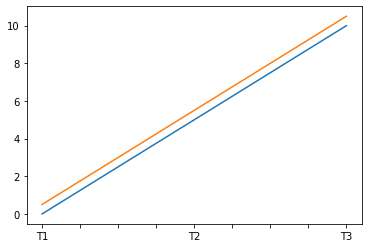

In [9]:
import matplotlib.pyplot as plt
class ReportingModule(ABC):
    
    @abstractmethod
    def graph_backtest_difference(self, historical_data, backtest_data):
        pass
    
class TestReportingModule(ReportingModule):
    
    def graph_backtest_difference(self, historical_data, backtest_data):
        historical_data["C1"].plot(kind='line')
        backtest_data["C1"].plot(kind='line')
        plt.show()
        
test_reporting_module = TestReportingModule()
test_reporting_module.graph_backtest_difference(historical_data, backtest_data)

## Digital Twin Abstract Class

/Users/seanmcowen/anaconda/envs/FinanceAndPython/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


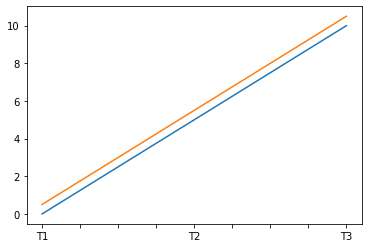

In [10]:
class DigitalTwin(ABC):
    
    def __init__(self, name, data_pipeline, backtest_model, stochastic_fit,
                signal_extrapolation, extrapolation_model, reporting_module,
                extrapolation_epochs = 7):
        self.name = name
        self.extrapolation_epochs = extrapolation_epochs
        
        self.data_pipeline = data_pipeline
        self.backtest_model = backtest_model
        self.stochastic_fit = stochastic_fit
        self.signal_extrapolation = signal_extrapolation
        self.extrapolation_model = extrapolation_model
        self.reporting_module = reporting_module
        
        self.historical_data = None
        self.input_data = None
        self.backtest_data = None
        self.stochastic_fit_params = None
        self.signals = None
        self.extrapolation_data = None
        
    
    @abstractmethod
    def load_data_initial(self):
        pass
    
    @abstractmethod
    def load_data_prior(self):
        pass
    
    @abstractmethod
    def compute_input_data(self):
        pass
    
    @abstractmethod
    def run_backtest(self):
        pass
    
    @abstractmethod
    def fit_stochastic_fit(self):
        pass
    
    @abstractmethod
    def extrapolate_signals(self):
        pass
    
    @abstractmethod
    def run_extrapolation(self):
        pass
    
    @abstractmethod
    def graph_backtest_difference(self):
        pass
    

class TestDigitalTwin(DigitalTwin):
        
    def load_data_initial(self):
        self.historical_data = self.data_pipeline.pull_historical_data()
        self.historical_data.to_csv("HistoricalData.csv")
    
    def load_data_prior(self):
        self.historical_data = pd.read_csv("HistoricalData.csv", index_col=0)
        
    def compute_input_data(self):
        self.input_data = self.data_pipeline.compute_input_data(self.historical_data)
    
    def run_backtest(self):
        backtest_data = self.backtest_model.run_model(self.input_data)
        backtest_data = self.backtest_model.post_processing(backtest_data)
        self.backtest_data = backtest_data
        
    def fit_stochastic_fit(self):
        self.stochastic_fit_params = test_stochastic_fit.fit_data(self.input_data)
        
    def extrapolate_signals(self):
        self.signals = self.signal_extrapolation.extrapolate_signals(stochastic_params, self.extrapolation_epochs)
    
    def run_extrapolation(self):
        extrapolation_data = self.extrapolation_model.run_model(self.signals, self.historical_data)
        extrapolation_data = self.extrapolation_model.post_processing(extrapolation_data)
        self.extrapolation_data = extrapolation_data
        
    def graph_backtest_difference(self):
        self.reporting_module.graph_backtest_difference(self.historical_data, self.backtest_data)
    
        
dt = TestDigitalTwin("Test1", test_pipeline, test_backtest_model, test_stochastic_fit,
                    test_signal_extrapolation, test_extrapolation_model, test_reporting_module)
dt.load_data_initial()
del(dt)
dt = TestDigitalTwin("Test1", test_pipeline, test_backtest_model, test_stochastic_fit,
                    test_signal_extrapolation, test_extrapolation_model, test_reporting_module)
dt.load_data_prior()
dt.compute_input_data()
dt.run_backtest()
dt.fit_stochastic_fit()
dt.extrapolate_signals()
dt.run_extrapolation()
dt.graph_backtest_difference()